In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as sps

connection = sqlite3.connect('german_credit.db')
cursor = connection.cursor()

def select(query):
    try:
        return pd.read_sql_query(query, connection)
    except:
        cursor.executescript(query)
        connection.commit()

In [3]:
german_credit = pd.read_csv('../german_credit_augmented.csv')
german_credit.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [3]:
german_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   job               1000 non-null   int64 
 3   housing           1000 non-null   object
 4   saving_accounts   817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   default           1000 non-null   int64 
 10  contract_dt       1000 non-null   object
 11  client_id         1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [4]:
(
    pd.pivot_table(german_credit, 
              index = 'sex',
              columns = 'housing',
              values = 'credit_amount',
              aggfunc = 'count')
    .T
    .assign(total_by_housing = lambda x: x.sum(axis = 1)).T
    .assign(total_by_sex = lambda x: x.sum(axis = 1))
    .assign(perc_gender = lambda x: x['total_by_sex'] * 100 / 1000)
    .T
    .assign(
        female_exp = lambda x: x['total_by_housing'] * 0.31,
        male_exp = lambda x: x['total_by_housing'] * 0.69
    ).T
)

housing,free,own,rent,total_by_sex,perc_gender
sex,,,,,
female,19.00,196.00,95.00,310.0,31.0
male,89.00,517.00,84.00,690.0,69.0
total_by_housing,108.00,713.00,179.00,1000.0,100.0
female_exp,33.48,221.03,55.49,310.0,31.0
male_exp,74.52,491.97,123.51,690.0,69.0


In [15]:
# Get expected distribution
def get_expected(df):
    sum_all = df.sum().sum()
    x_list = []
    for x in df.T.sum():
        y_list = []
        for y in df.sum():
            y_list.append(x * y)
        x_list.append(y_list)
    return pd.DataFrame(x_list, index = df.index + '_exp', columns = df.columns)/sum_all

In [25]:
df_result = (
    pd.pivot_table(german_credit, 
              index = 'sex',
              columns = 'housing',
              values = 'credit_amount',
              aggfunc = 'count')
)
(   
pd.concat([df_result.T.assign(sum_by_housing = lambda x: x.sum(axis = 1)).T, get_expected(df_result) ], axis=0)
.assign(total = lambda x: x.sum(axis = 1))
)

housing,free,own,rent,total
sex,,,,
female,19.00,196.00,95.00,310.0
male,89.00,517.00,84.00,690.0
sum_by_housing,108.00,713.00,179.00,1000.0
female_exp,33.48,221.03,55.49,310.0
male_exp,74.52,491.97,123.51,690.0


### Hypothesis
> $H_0: $
>     sex $\neq$ housing

| housing |	free |	own |	rent |	total|
| :-: |:-: |:-: |:-: |:-: |
|sex |	||||			
|female |	19| 	196| 	95| 	310|
|male |	89 	|517 |	84 	|690|
|total |	108 	|713 |	179 |	1000|

>Female total perc - 31% <br>
Male total perc - 69%

### Calculating formula
$$ f_{ij} = \frac{f_i \cdot f_j}{N} $$

| housing |	free |	own |	rent |	total|
| :-: |:-: |:-: |:-: |:-: |
|sex |	||||			
|female |	19| 	196| 	95| 	310|
|male |	89 	|517 |	84 	|690|
|sum_by_housing |	108 	|713 |	179 |	1000|
|female_exp |	33.48 |	221.03 |	55.49 |	310.0 |
|male_exp |	74.52 |	491.97 |123.51 | 	690.0 |

```=> 108 * 310 / 1000, 713 * 310 / 1000 etc.```

<br>
<center><img src="df_res.png" width="400"/></center>

<center><h3>Get expected from scipy.stats</h3></center>

<br>

<div class="alert alert-block alert-warning">

```import scipy.stats as sps```<br>
```sps.contingency.expected_freq(([10, 6], [5, 15]))```
</div>
<br>

### Task 1
>В таблице представлены результаты эксперимента, направленного на проверку гипотезы
>о взаимосвязи двух номинативных переменных с двумя градациями.
>Рассчитайте ожидаемые частоты для проверки нулевой гипотезы о независимости двух переменных X и Y.

<center><img src="https://ucarecdn.com/f5fdc068-01a7-4533-b9b2-fe3ed07de382/" width = 600></center>

В поле для ответа напишите максимальное значение из четырех ожидаемых частот.

In [8]:
df_task1 = pd.DataFrame([[10, 6], [5, 15]], index = ['first_y', 'second_y'], columns = ['first_x', 'second_x'])
df_task1

,first_x,second_x
first_y,10,6
second_y,5,15


In [19]:
get_expected(df_task1).max().max()

11.666666666666666

In [24]:
sps.contingency.expected_freq(([10, 6], [5, 15]))

array([[ 6.66666667,  9.33333333],
       [ 8.33333333, 11.66666667]])

<br>
<center><h1>Analysis of contingency table</h1></center>
<br>

```Поправка Йейтса:```
<br>

$$ \chi^2_{Yates} = \sum_{n = 1}^k \frac {(|f_o - f_e| - 0.5) ^ 2} {f_e}$$

<div class="alert alert-block alert-danger">
<b>Поправка Йейтса</b> на непрерывность – это процедура, разработанная британским статистиком Франком Йейтсом (Frank Yates) для критерия независимости хи-квадрат при работе с таблицами 2×2. Распределение хи-квадрат непрерывное, однако данные, используемые в критерии хи-квадрат, дискретные, и поправка Йейтса была придумана как раз для того, чтобы исправить это несоответствие [...]<br>
    Идея поправки Йейтса состоит в том, что уменьшение значения хи-квадрат приводит к уменьшению вероятности ошибки первого рода (ошибочного отвержения нулевой гипотезы). Однако использование поправки Йейтса одобряется далеко не всеми; некоторые исследователи считают, что она может приводить к слишком сильной коррекции с понижением мощности и повышению вероятности ошибки второго рода (ошибочного неотвержения нулевой гипотезы). Некоторые статистики отвергают поправку Йейтса в принципе, хотя другие находят ее полезной в случае разреженных данных, особенно если хотя бы в одной ячейке ожидаемая величина меньше 5.
</div>

<h3>Calculations in Python</h3>
<br>
<div class="alert alert-block alert-warning">

```from scipy.stats import chi2_contingency```<br>
```chi2, p_value, ddof, expected = chi2_contingency(observed_values)```
</div>
<br>


In [26]:
pd.pivot_table(german_credit, 
              index = 'sex',
              columns = 'housing',
              values = 'credit_amount',
              aggfunc = 'count')

housing,free,own,rent
sex,,,
female,19,196,95
male,89,517,84


In [37]:
chi2, p_value, dof, expected = sps.chi2_contingency(pd.pivot_table(german_credit, 
              index = 'sex',
              columns = 'housing',
              values = 'credit_amount',
              aggfunc = 'count'))
f'chi2 = {chi2}, p_value = {p_value}, dof = {ddof}'

'chi2 = 53.95497847218782, p_value = 1.922318250514252e-12, dof = 2'

<br>
<center> 
<h1>Contingency table age - housing from german_credit</h1>
</center>

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>age_groups</th>
      <th>young</th>
      <th>middle</th>
      <th>aged</th>
    </tr>
    <tr>
      <th>housing</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>free</th>
      <td>41</td>
      <td>49</td>
      <td>18</td>
    </tr>
    <tr>
      <th>own</th>
      <td>472</td>
      <td>199</td>
      <td>42</td>
    </tr>
    <tr>
      <th>rent</th>
      <td>143</td>
      <td>28</td>
      <td>8</td>
    </tr>
  </tbody>
</table>
</div>

In [4]:
df_age_housing = pd.pivot_table(
    german_credit
    .assign(age_groups = lambda x: pd.cut(x['age'], 3, labels = ['young', 'middle', 'aged'])),
    index = 'housing',
    columns = 'age_groups',
    values = 'credit_amount',
    aggfunc = 'count'
)
df_age_housing

age_groups,young,middle,aged
housing,,,
free,41,49,18
own,472,199,42
rent,143,28,8


<h3>Expected values</h3>
<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>age_groups</th>
      <th>young</th>
      <th>middle</th>
      <th>aged</th>
    </tr>
    <tr>
      <th>housing</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>free</th>
      <td>70.848</td>
      <td>29.808</td>
      <td>7.344</td>
    </tr>
    <tr>
      <th>own</th>
      <td>467.728</td>
      <td>196.788</td>
      <td>48.484</td>
    </tr>
    <tr>
      <th>rent</th>
      <td>117.424</td>
      <td>49.404</td>
      <td>12.172</td>
    </tr>
  </tbody>
</table>
</div>

In [39]:
pd.DataFrame(sps.contingency.expected_freq(df_age_housing), index = df_age_housing.index, columns = df_age_housing.columns)

age_groups,young,middle,aged
housing,,,
free,70.848,29.808,7.344
own,467.728,196.788,48.484
rent,117.424,49.404,12.172


<h3>Analysis of results</h3>

In [36]:
sps.chi2_contingency(df_age_housing)

Chi2ContingencyResult(statistic=57.598175579621895, pvalue=9.266549685484865e-12, dof=4, expected_freq=array([[ 70.848,  29.808,   7.344],
       [467.728, 196.788,  48.484],
       [117.424,  49.404,  12.172]]))

<div class = 'alert alert-block alert-info'>
    
> P-value < 0.05  $=>$ We reject 
$H_0$ hypotisis

</div>

<h3>Task 2</h3>
<p>Перед знаком стоп некоторые водители останавливаются полностью, другие лишь сбавляют скорость, но некоторые не останавливаются вообще. Важнейший вопрос, есть ли взаимосвязь между полом и стилем вождения автомобиля!  Ниже представлена таблица сопряженности данных исследования, посвященного этому вопросу.</p>

<center><img alt="" height="126" src="https://ucarecdn.com/fd5dfb7a-4de4-4e78-bfb1-c3fb2a5943e0/" width="410"></center>

<div class='alert alert-block alert-success '>

> Zero hypotisis: men and women stoped, slower, don't stop in equal probability
</div>

In [42]:
df_stop = pd.DataFrame([[20, 15], [11, 12], [7, 9]], index = ['stopped', 'slow', 'not_stopped'], columns = ['male', 'female'])
df_stop

,male,female
stopped,20,15
slow,11,12
not_stopped,7,9


<h3>Expected frequencies</h3>

In [44]:
pd.DataFrame(sps.contingency.expected_freq(df_stop), index = df_stop.index, columns = df_stop.columns)

,male,female
stopped,17.972973,17.027027
slow,11.810811,11.189189
not_stopped,8.216216,7.783784


<h3>Results</h3>

In [59]:
chi, p_value, *tr = sps.chi2_contingency(df_stop)
f'chi = {chi}, p_value = {p_value}'

'chi = 0.9544070774762996, p_value = 0.6205162173513055'

<div class = 'alert alert-block alert-info'>

> Value of p-value > 0.05, we can't reject zero hypotisis
</div>

<center><h1>Visualization of residuals</h1></center>

In [108]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

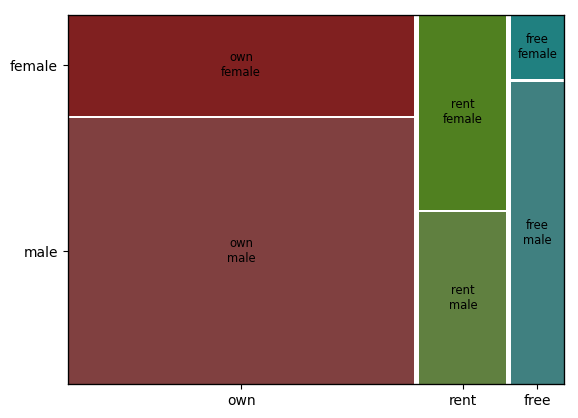

In [109]:
mosaic(german_credit, ['housing', 'sex'], gap = 0.01);